In [36]:
import os
import pickle
import numpy as np
from tqdm import tqdm

root = 'data'
saved_file = 'features_cache.pkl'

# 載入已經存的資料
if os.path.exists(saved_file):
    print("Loading saved features...")
    with open(saved_file, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    name = data['name']
    loaded_names = set(name)
else:
    features = []
    name = []
    loaded_names = set()

# 讀取新資料夾
for subdir_entry in os.scandir(root):
    if not subdir_entry.is_dir():
        continue
    subdir_path = os.path.join(subdir_entry.path, 'KEYPOINT_DIR')
    if not os.path.exists(subdir_path):
        continue

    try:
        for f_entry in os.scandir(subdir_path):
            if not f_entry.is_dir():
                continue

            if f_entry.path in loaded_names:
                continue

            feature = []
            npy_files = sorted([
                entry.path for entry in os.scandir(f_entry.path)
                if entry.is_file() and entry.name.endswith('.npy')
            ])
            for npy_path in tqdm(npy_files, desc=f"Loading {f_entry.name}"):
                feature.append(np.load(npy_path, allow_pickle=False))
            if feature:
                features.append(np.array(feature))
                name.append(f_entry.path)
                loaded_names.add(f_entry.path)

    except Exception as e:
        print(f"Skipping {subdir_entry.name} due to error: {e}")

# 保存到 pickle
with open(saved_file, 'wb') as f:
    pickle.dump({'features': features, 'name': name}, f)

print(f"Saved features to {saved_file}")


Loading saved features...


Loading pitch_0055: 100%|██████████| 150/150 [00:03<00:00, 40.30it/s] 


Saved features to features_cache.pkl


In [37]:
import os
import pandas as pd
from tqdm import tqdm

# Step1: 先找到所有球員 CSV，讀取並合併成一個大 DataFrame
csv_cache = {}

for j in name:
    parts = j.split(os.sep)
    player_folder = parts[1]
    player_name = player_folder.replace("_videos_4S", "")
    csv_path = os.path.join('data', player_folder, f"{player_name}.csv")
    if csv_path not in csv_cache and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # 建立映射 key 是影片小寫檔名，value 是 description
        csv_cache[csv_path] = {k.lower(): v for k, v in zip(df['Filename'], df['description'])}

# Step2: 用 cache 查詢 label，速度會快很多
y = []
for j in tqdm(name):
    parts = j.split(os.sep)
    player_folder = parts[1]
    video_name = parts[-1] + '.mp4'
    player_name = player_folder.replace("_videos_4S", "")
    csv_path = os.path.join('data', player_folder, f"{player_name}.csv")

    if csv_path in csv_cache:
        label = csv_cache[csv_path].get(video_name.lower(), 'Unknown')
    else:
        label = 'Unknown'

    y.append(label)

# 測試輸出
for i, label in zip(features, y):
    print(i.shape, label)


100%|██████████| 55/55 [00:00<00:00, 110482.15it/s]

(153, 17, 3) ball
(151, 17, 3) foul
(10, 17, 3) hit_into_play
(69, 17, 3) hit_into_play
(238, 17, 3) ball
(98, 17, 3) foul
(32, 17, 3) foul
(138, 17, 3) called_strike
(49, 17, 3) ball
(89, 17, 3) ball
(120, 17, 3) called_strike
(82, 17, 3) ball
(105, 17, 3) ball
(103, 17, 3) foul
(5, 17, 3) ball
(238, 17, 3) ball
(30, 17, 3) foul
(65, 17, 3) ball
(238, 17, 3) ball
(112, 17, 3) hit_into_play
(74, 17, 3) ball
(89, 17, 3) blocked_ball
(239, 17, 3) foul
(17, 17, 3) ball
(239, 17, 3) foul
(238, 17, 3) ball
(238, 17, 3) ball
(98, 17, 3) ball
(238, 17, 3) blocked_ball
(238, 17, 3) ball
(236, 17, 3) ball
(239, 17, 3) foul
(102, 17, 3) hit_into_play
(238, 17, 3) ball
(119, 17, 3) swinging_strike
(52, 17, 3) hit_into_play
(9, 17, 3) swinging_strike
(118, 17, 3) hit_into_play
(98, 17, 3) hit_into_play
(238, 17, 3) swinging_strike
(238, 17, 3) ball
(76, 17, 3) ball
(8, 17, 3) ball
(238, 17, 3) ball
(238, 17, 3) swinging_strike
(238, 17, 3) ball
(136, 17, 3) ball
(120, 17, 3) ball
(24, 17, 3) ball


In [38]:
import pandas as pd

# 建立一個 dict
data_dict = {
    'feature': features,
    'label': y,
    'path': name
}
df = pd.DataFrame(data_dict)
df['label_binary'] = df['label'].apply(lambda x: 0 if 'strike' in x.lower() else 1)
print(df['label_binary'].value_counts())

import numpy as np

def pad_or_truncate_sequence(seq, target_len):
    """統一所有樣本的 seq_len"""
    seq_len, joints, dims = seq.shape
    if seq_len == target_len:
        return seq
    elif seq_len < target_len:
        pad_len = target_len - seq_len
        pad_shape = (pad_len, joints, dims)
        pad = np.zeros(pad_shape, dtype=np.float32)
        return np.concatenate([seq, pad], axis=0)
    else:
        return seq[:target_len]  # truncate
target_len = 200  # 例如選定 30 frame 為統一長度
df['feature_padded'] = df['feature'].apply(lambda x: pad_or_truncate_sequence(x, target_len))

from sklearn.model_selection import train_test_split

X = np.stack(df['feature_padded'].values)  # shape: (samples, 30, joints, dims)
y = df['label_binary'].values

# optional: 合併 joints/dims 維度以餵給 TCN（通常 TCN 接收 (batch, seq_len, input_dim)）
X = X.reshape(X.shape[0], X.shape[1], -1)  # → shape: (samples, 30, joints*dims)

# 2. normalize (per-feature across all samples and time steps)
# reshape to 2D temporarily to fit scaler: (samples * seq_len, input_dim)
X_2d = X.reshape(-1, X.shape[2])
mean = X_2d.mean(axis=0)
std = X_2d.std(axis=0) + 1e-8  # 防止除以0

X_norm = (X - mean) / std  # broadcasting back to 3D

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

# 我要對x做正規化要加在哪裡


label_binary
1    49
0     6
Name: count, dtype: int64


In [39]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class PoseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(PoseDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(PoseDataset(X_test, y_test), batch_size=32)


In [40]:
class SimpleTCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=2, dilation=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, input_dim, seq_len)
        x = self.tcn(x)  # (batch, hidden_dim, 1)
        x = x.squeeze(-1)
        return self.fc(x)


In [41]:
import torch
from sklearn.metrics import accuracy_score

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    preds, targets = [], []

    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds += torch.argmax(output, dim=1).cpu().tolist()
        targets += y_batch.cpu().tolist()

    epoch_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(targets, preds)
    return epoch_loss, acc

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            preds += torch.argmax(output, dim=1).cpu().tolist()
            targets += y_batch.cpu().tolist()

    epoch_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(targets, preds)
    return epoch_loss, acc


In [42]:
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = X_train.shape[2]

model = SimpleTCN(input_dim=input_dim).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, test_loader, criterion, device)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 01 | Train Loss: 0.6900, Acc: 0.6136 | Val Loss: 0.5254, Acc: 1.0000
Epoch 02 | Train Loss: 0.5608, Acc: 0.8636 | Val Loss: 0.3796, Acc: 1.0000
Epoch 03 | Train Loss: 0.4756, Acc: 0.8636 | Val Loss: 0.2493, Acc: 1.0000
Epoch 04 | Train Loss: 0.4211, Acc: 0.8636 | Val Loss: 0.1607, Acc: 1.0000
Epoch 05 | Train Loss: 0.4105, Acc: 0.8636 | Val Loss: 0.1115, Acc: 1.0000
Epoch 06 | Train Loss: 0.4190, Acc: 0.8636 | Val Loss: 0.0890, Acc: 1.0000
Epoch 07 | Train Loss: 0.4300, Acc: 0.8636 | Val Loss: 0.0793, Acc: 1.0000
Epoch 08 | Train Loss: 0.4290, Acc: 0.8636 | Val Loss: 0.0855, Acc: 1.0000
Epoch 09 | Train Loss: 0.4176, Acc: 0.8636 | Val Loss: 0.1081, Acc: 1.0000
Epoch 10 | Train Loss: 0.4033, Acc: 0.8636 | Val Loss: 0.1440, Acc: 1.0000
Epoch 11 | Train Loss: 0.3963, Acc: 0.8636 | Val Loss: 0.1823, Acc: 1.0000
Epoch 12 | Train Loss: 0.4004, Acc: 0.8636 | Val Loss: 0.2115, Acc: 1.0000
Epoch 13 | Train Loss: 0.4017, Acc: 0.8636 | Val Loss: 0.2209, Acc: 1.0000
Epoch 14 | Train Loss: 0.

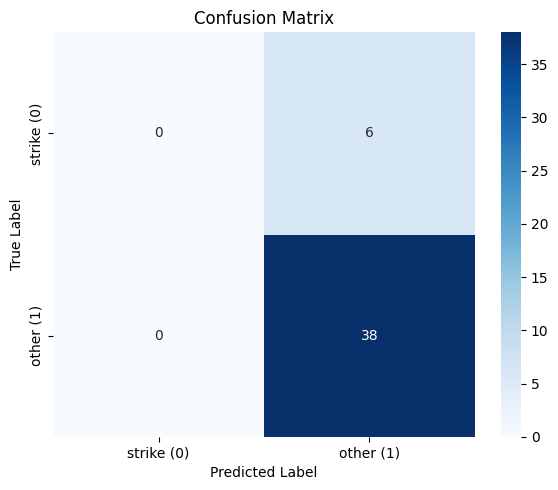

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 計算混淆矩陣
y_true = y_train
y_pred = model(torch.tensor(X_train, dtype=torch.float32)).argmax(dim=1).numpy()
cm = confusion_matrix(y_true, y_pred)

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['strike (0)', 'other (1)'],
            yticklabels=['strike (0)', 'other (1)'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


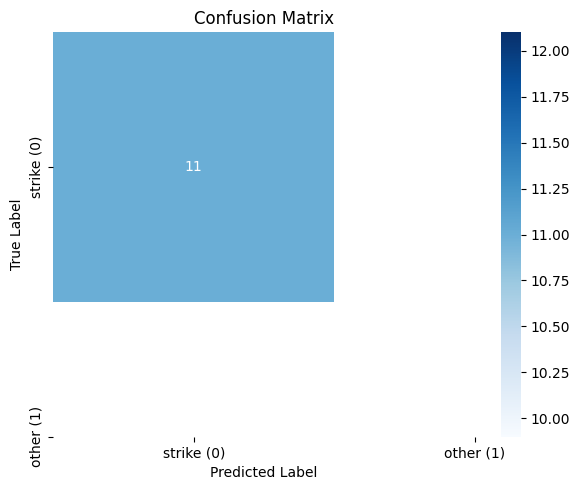

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 計算混淆矩陣
y_true = y_test
y_pred = model(torch.tensor(X_test, dtype=torch.float32)).argmax(dim=1).numpy()
cm = confusion_matrix(y_true, y_pred)

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['strike (0)', 'other (1)'],
            yticklabels=['strike (0)', 'other (1)'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
